### Librerie

In [51]:
seed = 42
scale = 0.9

# Librerie necessarie
from glob import glob
import numpy as np
np.random.seed(seed)
import matplotlib.pyplot as plt
import logging

import skimage.transform
import os
from scipy.ndimage import zoom
from skimage import exposure

import pydicom as dicom

import cv2

from PIL import Image

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

from __future__ import print_function
import skimage.io as io
import skimage.transform as trans

from keras.preprocessing.image import ImageDataGenerator
from keras import backend as keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

2.13.0


### Classi Per il progetto

In [52]:
class Abstract_volum:
    def __init__(self, path):
        self.path = path
        self.img_vol_raw = None
        self.img_vol_ela = None
        
    def cropping(self,scale=1.0):
        center_x, center_y = self.img_vol_ela.shape[1] / 2, self.img_vol_ela.shape[2] / 2
        # print(center_x, center_y)
        width_scaled, height_scaled = self.img_vol_ela.shape[1] * scale, self.img_vol_ela.shape[2] * scale
        left_x, right_x = center_x - width_scaled / 2, center_x + width_scaled / 2
        top_y, bottom_y = center_y - height_scaled / 2, center_y + height_scaled / 2
        
        # print(self.img_vol_raw.shape[0], int(left_x - right_x), int(top_y- bottom_y))
        
        aux = np.empty(shape=(self.img_vol_raw.shape[0], int(right_x) - int(left_x), int(bottom_y)-int(top_y)))
        
        for i in range((self.img_vol_raw.shape[0])):
            aux[i,:,:] = self.img_vol_ela[i, int(top_y):int(bottom_y), int(left_x):int(right_x)]
              
        self.img_vol_ela = aux

    def get_middle_slice(self, volum):
        return int(np.round(volum.shape[0]/2))

    def get_image_ela(self): 
        # print ('Middle slice image 1: ', mid_slice_1)
        fig = plt.figure(figsize=(4,4))
        a = fig.add_subplot(1,1,1)
        # print(self.get_middle_slice(self.img_vol_ela))
        # print(self.img_vol_raw [self.get_middle_slice(self.img_vol_raw), :, :])
        imgplot = plt.imshow(self.img_vol_ela [self.get_middle_slice(self.img_vol_ela), :, :], cmap = 'gray')

class MR(Abstract_volum):
    def __init__(self, path):
        super().__init__(path)

        img_vol = []
        for path, _, files in sorted(os.walk(self.path)): 
            for filename in (sorted(files)): 
                if filename.endswith (dcm_ext):
                    # print (filename)                                              # uncomment if you want see the name of the slice
                    img_dcm_std = dicom.dcmread(os.path.join(self.path,filename))   # Funzione che legge i file dato il percoso
                    img = img_dcm_std.pixel_array                                   # estraiamo la matrice dell'immagine
                    img_vol.append (img)                                            # aggiungo immagine al volume

        self.img_vol_raw = np.array (img_vol)

        z_space = img_dcm_std.SpacingBetweenSlices
        x_space = img_dcm_std.PixelSpacing [0]
        y_space = img_dcm_std.PixelSpacing [1]

        self.vox_dims = (x_space, y_space, z_space) # I vox dims non voglio che siano la attributi del volume

        self.img_vol_ela = self.img_vol_raw

    def reseampling(self):
        """
        RESEAMPLING DEI VOXEL
            1) Definisco il mio voxel target, hai due posibilità:
                - scegli arbitrariamente (come in questo caso)
                - Fai la media di tutti i voxel
            2) Calcolo il mio vettore di scala: semplicemnte il rapporto fra i miei vettori di scala: dim di partenza dei voxel/dim di target
            3) Funzione che modifica la foto secondo il vettore
        """
        target_resolution = (1, 1, 1)
        scale_vector = (self.vox_dims[0]/target_resolution[0], self.vox_dims[1]/target_resolution[1], self.vox_dims[2]/target_resolution[2])
        
        self.vox_dims = target_resolution
        self.img_vol_ela = skimage.transform.rescale(self.img_vol_ela, scale_vector, order=3, preserve_range=True,  mode='constant')    

    def resizing(self):
        """
        RESIZE DELL'IMMAGINE: devo fare uno zoom
            1) Definisco la dimesione target
            2) Definisco il fattore di scala
            3) Passo volume, vettore di scale e un ordine (nel reseampling viene fatta interpolazione):
                - order 3 if images are in grey scale
                - order 0 if images are binary scale

        Ho ottenuto immagini di dim uguali in tutte le direzioni
        """
        target_shape = [192, 192, 192] 
        factors_1 = (
            target_shape[0]/self.img_vol_ela.shape[0],
            target_shape[1]/self.img_vol_ela.shape[1], 
            target_shape[2]/self.img_vol_ela.shape[2]
        )

        # print(factors_1)

        self.img_vol_ela = zoom(self.img_vol_ela, factors_1, order=3, mode= 'nearest') 

    def standardization(self): # a me non sembra faccia un tubo
        img_o = np.float32(self.img_vol_ela.copy())
        m = np.mean(img_o)
        s = np.std(img_o)
        self.img_vol_ela = np.divide((img_o - m), s)       # return the normalize image

        # print((volums[0].img_vol_raw == lrrnormalized_img).all())

    def normalization(self):
        self.img_vol_ela = cv2.normalize(self.img_vol_ela, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8UC1)

    def equalizzazione(self):
        # eq_img_1 = cv2.equalizeHist(norm_image [volums[0].get_middle_slice(), :, :])      # equalizzazione dell'istogramma tradizionale (applicato a immagine complessiva) PEGGIORE
        clahe_img = cv2.createCLAHE (clipLimit = 2.0, tileGridSize = (8, 8))                # equalizzazione adattiva (algo clahe) MIGLIORE

        # print(type(clahe_img.apply (self.img_vol_ela[1, :, :])))

        aux = np.empty(shape=(192, 192, 192))
        for i in range(192):
            aux[i,:,:] = clahe_img.apply(self.img_vol_ela[i, :, :])
        
        self.img_vol_ela = aux

    def pre_processing(self):
        # self.cropping(scale)
        # print("post cropping: " + str(self.img_vol_ela.shape))
        
        self.reseampling()
        # print("post reseampling: " + str(self.img_vol_ela.shape))
        self.resizing()
        # print("post resizing: " + str(self.img_vol_ela.shape))
        self.standardization()
        # print("post standardization: " + str(self.img_vol_ela.shape))
        self.normalization()
        # print("post normalization: " + str(self.img_vol_ela.shape))
        self.equalizzazione()
        # print("post equalizzazione: " + str(self.img_vol_ela.shape))
        # print("post pre-processing: " + str(self.img_vol_ela.shape))

    def compare_images_pre_post_processing(self):   
        fig = plt.figure(figsize=(8,8))

        a = fig.add_subplot(1, 2, 1)
        imgplot = plt.imshow(self.img_vol_raw [(self.get_middle_slice(self.img_vol_raw)), :, :], cmap = 'gray')

        a = fig.add_subplot(1, 2, 2)
        imgplot = plt.imshow(self.img_vol_ela [(self.get_middle_slice(self.img_vol_ela)), :, :], cmap = 'gray')
 
    def __str__(self):
        return self.path + "\n" + str(self.vox_dims) + "\n" + str(self.img_vol_raw.shape) + "\n" + str(self.img_vol_ela.shape)

class Segmentation(Abstract_volum):
    def __init__(self, path):
        super().__init__(path)
        
        img_seg = [] 
        for path, _, files in sorted(os.walk(self.path)): 
            for filename in (sorted(files)): 
                if filename.endswith (img_ext):
                        # print (filename)                                              # uncomment if you want see the name of the slice
                        # img = cv2.imread(os.path.join(self.path,filename))              # Funzione che legge i file dato il percoso
                        img = np.array(Image.open(os.path.join(path,filename)))
                        img_seg.append (img)                                            # aggiungo immagine al volume

        self.img_vol_raw = np.array (img_seg)

        self.img_vol_ela = self.img_vol_raw

    def resizing(self):
        """
        RESIZE DELL'IMMAGINE: devo fare uno zoom
        1) Definisco la dimesione target
        2) Definisco il fattore di scala
        3) Passo volume, vettore di scale e un ordine (nel reseampling viene fatta interpolazione):
                - order 3 if images are in grey scale
                - order 0 if images are binary scale

        Ho ottenuto immagini di dim uguali in tutte le direzioni
        """
        target_shape = [192, 192, 192] 
        factors_1 = (
            target_shape[0]/self.img_vol_ela.shape[0],
            target_shape[1]/self.img_vol_ela.shape[1], 
            target_shape[2]/self.img_vol_ela.shape[2],
            # target_shape[3]/self.img_vol_ela.shape[3]
        )

        # print(factors_1)

        self.img_vol_ela = zoom(self.img_vol_ela, factors_1, order=0, mode= 'nearest') 

    def __str__(self):
        return self.path + "\n" + str(self.img_vol_ela.shape)   # + "\n" + str(self.img_vol_ela.shape)


### Funzione di supporto

In [53]:
def create_volums(root, suff):
    '''
    Function that create return an array of MR (magnetic resonance) or Segmentation
    Given the path of the folder that contains the files
    '''
    paths = sorted(glob(os.path.join(root, "*", suff)))
    volums = []
    for path in paths:
        if suff[-8:] == "/Ground/":
            volum = Segmentation(path)
        else: 
            volum = MR(path)
        volums.append(volum)

    return volums

### Setting paths

In [54]:
root_MR = "/kaggle/input/datasett1/MR"
suff_InPhase = "T1DUAL/DICOM_anon/InPhase/"
suff_OutPhase = "T1DUAL/DICOM_anon/OutPhase/"
dcm_ext = '.dcm'

root_Seg = "/kaggle/input/datasett1/MR"
suff = "T1DUAL/Ground/"
img_ext = '.png'

### Pre-processing MR

In [55]:
# Creo MR:

mrs = create_volums(root_MR, suff_InPhase) # + create_volums(root_MR, suff_OutPhase)

for mr in mrs:
    print(mr)
    mr.pre_processing()
    print(mr)

/kaggle/input/datasett1/MR/1/T1DUAL/DICOM_anon/InPhase/
('1.89453125', '1.89453125', '5.5')
(35, 256, 256)
(35, 256, 256)
/kaggle/input/datasett1/MR/1/T1DUAL/DICOM_anon/InPhase/
(1, 1, 1)
(35, 256, 256)
(192, 192, 192)
/kaggle/input/datasett1/MR/10/T1DUAL/DICOM_anon/InPhase/
('1.89453125', '1.89453125', '5.5')
(50, 256, 256)
(50, 256, 256)
/kaggle/input/datasett1/MR/10/T1DUAL/DICOM_anon/InPhase/
(1, 1, 1)
(50, 256, 256)
(192, 192, 192)
/kaggle/input/datasett1/MR/13/T1DUAL/DICOM_anon/InPhase/
('1.44097220897674', '1.44097220897674', '9.0')
(30, 288, 288)
(30, 288, 288)
/kaggle/input/datasett1/MR/13/T1DUAL/DICOM_anon/InPhase/
(1, 1, 1)
(30, 288, 288)
(192, 192, 192)
/kaggle/input/datasett1/MR/15/T1DUAL/DICOM_anon/InPhase/
('1.69921875', '1.69921875', '9.0')
(26, 256, 256)
(26, 256, 256)
/kaggle/input/datasett1/MR/15/T1DUAL/DICOM_anon/InPhase/
(1, 1, 1)
(26, 256, 256)
(192, 192, 192)
/kaggle/input/datasett1/MR/19/T1DUAL/DICOM_anon/InPhase/
('1.44097220897674', '1.44097220897674', '9.0')
(

### Pre-processing Segmentazioni

/kaggle/input/datasett1/MR/1/T1DUAL/Ground/
(35, 256, 256)
/kaggle/input/datasett1/MR/1/T1DUAL/Ground/
(192, 192, 192)
/kaggle/input/datasett1/MR/10/T1DUAL/Ground/
(50, 256, 256)
/kaggle/input/datasett1/MR/10/T1DUAL/Ground/
(192, 192, 192)
/kaggle/input/datasett1/MR/13/T1DUAL/Ground/
(30, 288, 288)
/kaggle/input/datasett1/MR/13/T1DUAL/Ground/
(192, 192, 192)
/kaggle/input/datasett1/MR/15/T1DUAL/Ground/
(26, 256, 256)
/kaggle/input/datasett1/MR/15/T1DUAL/Ground/
(192, 192, 192)
/kaggle/input/datasett1/MR/19/T1DUAL/Ground/
(30, 288, 288)
/kaggle/input/datasett1/MR/19/T1DUAL/Ground/
(192, 192, 192)
/kaggle/input/datasett1/MR/2/T1DUAL/Ground/
(26, 288, 288)
/kaggle/input/datasett1/MR/2/T1DUAL/Ground/
(192, 192, 192)
/kaggle/input/datasett1/MR/20/T1DUAL/Ground/
(26, 288, 288)
/kaggle/input/datasett1/MR/20/T1DUAL/Ground/
(192, 192, 192)
/kaggle/input/datasett1/MR/21/T1DUAL/Ground/
(34, 256, 256)
/kaggle/input/datasett1/MR/21/T1DUAL/Ground/
(192, 192, 192)
/kaggle/input/datasett1/MR/22/T1DUAL

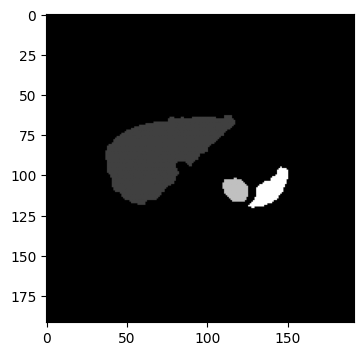

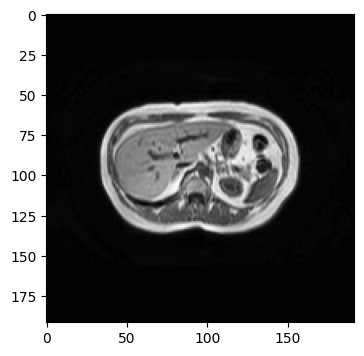

In [56]:
# Creo Segmentations

segs = create_volums(root_Seg, suff)

# To process all test set
for seg in segs:
    print(seg)
    seg.cropping(scale)
    seg.resizing()
    print(seg)

segs[1].get_image_ela()
mrs[1].get_image_ela()

### Labels

In [57]:
def map_category(value):
    if 55 <= value <= 70:
        return 1  # Liver
    elif 110 <= value <= 135:
        return 2  # Right kidney
    elif 175 <= value <= 200:
        return 3  # Left kidney
    elif 240 <= value <= 255:
        return 4  # Spleen
    else:
        return 0  # Unlabelled

In [58]:
mrs_merged = np.concatenate([mrs[i].img_vol_ela[..., np.newaxis] for i in range(len(mrs))], axis=0)
print(mrs_merged.shape)

(3840, 192, 192, 1)


In [59]:
segs_merged = np.concatenate([segs[i].img_vol_ela[..., np.newaxis] for i in range(len(segs))], axis=0)
print(mrs_merged.shape)

(3840, 192, 192, 1)


In [60]:
# Applica la nuova mappatura a 'merged_labels'
segs_merged = np.vectorize(map_category)(segs_merged)

# Conta il numero di classi uniche
unique_labels, counts = np.unique(segs_merged, return_counts=True)
print(unique_labels), print(counts)

[0 1 2 3 4]
[133522475   5756009    618734    644782   1015760]


(None, None)

In [61]:
def display_color_mapped_image_continuous(image, n_colors=5):
    """
    Display an image with colors mapped from a given image array using a continuous colormap.
    The image array should contain integer values from 0 to n_colors-1, where each integer
    represents a different color sampled linearly from the colormap.

    Args:
    image (ndarray): An array of shape (H, W) containing integer values from 0 to n_colors-1.
    n_colors (int): The number of colors to use from the colormap. Max 30.
    """
    if n_colors > 5:
        raise ValueError("Maximum number of colors is 5.")
    if not (0 <= image.min() and image.max() < n_colors):
        raise ValueError("Image values should be in the range [0, n_colors-1].")

    # Using a continuous colormap (like 'viridis') and sampling linearly
    cmap = plt.get_cmap('magma') #hot,magma,cividis
    colors = cmap(np.linspace(0, 1, n_colors))

    # Map the colors
    colored_image = colors[image]

    return colored_image

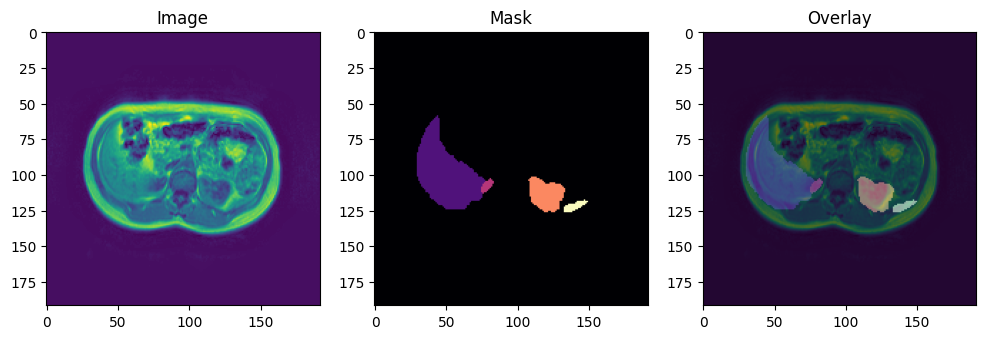

In [62]:
def plot_pairs(data, labels, index=None):
    if index == None:
        index = np.random.randint(0,len(data))
    fig, axes = plt.subplots(1, 3, figsize=(12,4))
    axes[0].set_title("Image")
    axes[0].imshow(data[index])
    axes[1].set_title("Mask")
    colored_image = display_color_mapped_image_continuous(labels[index])
    axes[1].imshow(np.squeeze(colored_image))

  # Sovrapposizione della terza immagine con trasparenza
    axes[2].set_title("Overlay")
    axes[2].imshow(data[index])
    overlay_alpha = 0.5  # Regola il valore alpha a tuo piacimento
    axes[2].imshow(np.squeeze(colored_image), alpha=overlay_alpha)

    plt.show()
    
plot_pairs(mrs_merged,segs_merged) #togli l indice[0,2839] per vedere immagini a caso

In [63]:
#Save processed data: merged_vols, merged_labels_04
np.savez('processed-nparray-MR-T1DUAL-InPhase.npz', mrs_merged=mrs_merged, segs_merged=segs_merged)

In [64]:
# Load .npz
loaded_data = np.load('processed-nparray-MR-T1DUAL-InPhase.npz')

# Estrai gli array utilizzando i loro nomi specificati durante il salvataggio
merged_vols = loaded_data['mrs_merged']
merged_labels_04 = loaded_data['segs_merged']
print(mrs_merged.shape), print(segs_merged.shape)

(3840, 192, 192, 1)
(3840, 192, 192, 1)


(None, None)

# Rete

In [65]:
#num_classes=len(unique_labels)
num_classes =5
print(num_classes)

5


### Splitto il dataset:
* training set: 0-15 patient
* validation set: 16-17 patient
* test set: 18-19 patient

In [66]:
X_train = mrs_merged[:16*192]
X_val = mrs_merged[16*192:18*192]
X_test = mrs_merged[18*192:]

y_train = segs_merged[:16*192]
y_val = segs_merged[16*192:18*192]
y_test = segs_merged[18*192:]

# Verifico la forma degli arrays

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((3072, 192, 192, 1),
 (3072, 192, 192, 1),
 (384, 192, 192, 1),
 (384, 192, 192, 1),
 (384, 192, 192, 1),
 (384, 192, 192, 1))

### Architecture
passo le slide alla rete quindi ha forma:

In [67]:
input_shape = X_train.shape[1:]
print('Input shape',input_shape)

Input shape (192, 192, 1)


### Mescolo i pazienti

In [68]:
from sklearn.utils import shuffle

# Shuffling dati
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

In [69]:
data_gen_args = dict()

### Unet

In [70]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):

    x = input_tensor
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=3, padding='same', name=name+'conv'+str(i+1))(x)
        x = tfkl.BatchNormalization(name=name+'bn'+str(i+1))(x)
        x = tfkl.Activation(activation, name=name+'activation'+str(i+1))(x)

    return x

In [71]:
def get_unet_model(input_shape=input_shape, num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # First Downsampling
    down_block_1 = unet_block(input_layer, 64, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    # Second Downsampling
    down_block_2 = unet_block(d1, 128, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Third Downsampling
    down_block_3 = unet_block(d2, 256, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)

    # Forth Downsampling
    down_block_4 = unet_block(d3, 512, name='down_block4_')
    d4 = tfkl.MaxPooling2D()(down_block_4)

    # Bottleneck
    bottleneck = unet_block(d4, 512, name='bottleneck')

    # First Upsampling (è simmetrico: il primo upsampling prende l ultimo downsampling)
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Add(name='add1')([u1,down_block_4]) #skip connection
    u1 = unet_block(u1, 256, name='up_block1_')

    # Second Upsampling
    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Add(name='add2')([u2,down_block_3])
    u2 = unet_block(u2, 128, name='up_block2_')

    # Third Upsampling
    u3 = tfkl.UpSampling2D()(u2)
    u3 = tfkl.Add(name='add3')([u3,down_block_2])
    u3 = unet_block(u3, 64, name='up_block3_')

    # Forth Upsampling
    u4 = tfkl.UpSampling2D()(u3)
    u4 = tfkl.Add(name='add4')([u4,down_block_1])
    u4 = unet_block(u4, 64, name='up_block4_')

    # Output Layer
    output_layer = tf.keras.layers.Conv2D(num_classes, kernel_size=3, padding='same', activation="softmax", name='output_layer')(u4)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

In [72]:
model = get_unet_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 192, 192, 1)]        0         []                            
                                                                                                  
 down_block1_conv1 (Conv2D)  (None, 192, 192, 64)         640       ['input_layer[0][0]']         
                                                                                                  
 down_block1_bn1 (BatchNorm  (None, 192, 192, 64)         256       ['down_block1_conv1[0][0]']   
 alization)                                                                                       
                                                                                                  
 down_block1_activation1 (A  (None, 192, 192, 64)         0         ['down_block1_bn1[0][0]'

### Custom Callbacks

In [73]:
# Define a custom metric class for mean intersection over union (IoU)
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes=None, name="mean_iou", dtype=None):
        super(UpdatedMeanIoU, self).__init__(num_classes=num_classes, name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

# Define a callback class for visualization during training
class VizCallback(tf.keras.callbacks.Callback):

    def __init__(self, image, label):
        super().__init__()
        self.image = image
        self.label = label

    def on_epoch_end(self, epoch, logs=None):
        # Predict using the model and visualize ground truth vs predicted mask
        pred = model.predict(self.image, verbose=0)
        y_pred = tf.math.argmax(pred, axis=-1)
        y_pred = np.array(y_pred)
        y_pred = np.reshape(y_pred, (192, 192, 1)) #(128, 256, 1)
        fig, axes = plt.subplots(1, 2, figsize=(12, 12)) #(16, 4)
        axes[0].imshow(np.squeeze(self.label))
        axes[0].set_title("Ground Truth Mask")
        colored_image = display_color_mapped_image_continuous(y_pred)
        axes[1].imshow(np.squeeze(colored_image))
        axes[1].set_title("Predicted Mask")
        plt.tight_layout()
        plt.show()

In [74]:
learning_rate = 1e-3
batch_size = 16
epochs = 1000

# sarebbe il caso di avere accuracy dedicate perchè tu non hai classificazione binaria! hai fegato, ecc...
# accuracy background sarà altissima! devi usare accuracy dedicate! --> ACCURACY PER CLASSE!

model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(), # 'binary_crossentropy', # 
    optimizer = tfk.optimizers.AdamW(learning_rate),
    metrics = ["accuracy", UpdatedMeanIoU(num_classes=num_classes)] # "accuracy"
    )

patience = 5
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_mean_iou', mode='max', patience=patience, restore_best_weights=True)
viz_callback = VizCallback(np.expand_dims(X_val[0],axis=0), np.expand_dims(y_val[0],axis=0))
scheduler = tfk.callbacks.ReduceLROnPlateau(monitor='val_mean_iou', mode='max', factor=0.1, patience=patience-5, min_lr=1e-5)

Epoch 1/1000


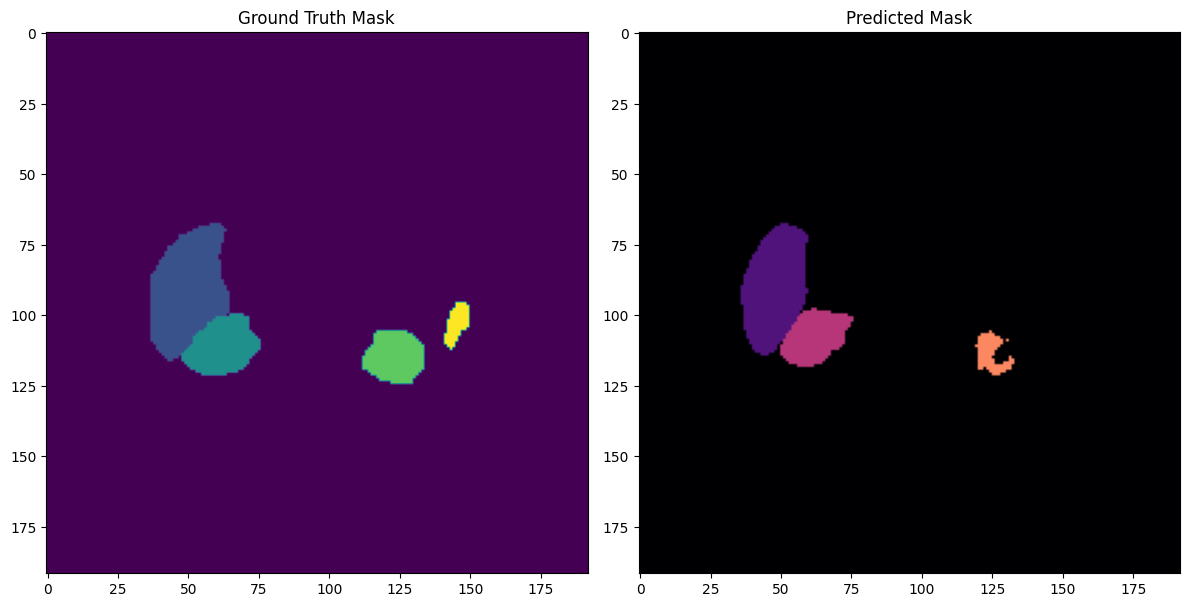

192/192 - 80s - loss: 0.0818 - accuracy: 0.9740 - mean_iou: 0.5339 - val_loss: 0.0757 - val_accuracy: 0.9787 - val_mean_iou: 0.4869 - lr: 0.0010 - 80s/epoch - 419ms/step
Epoch 2/1000


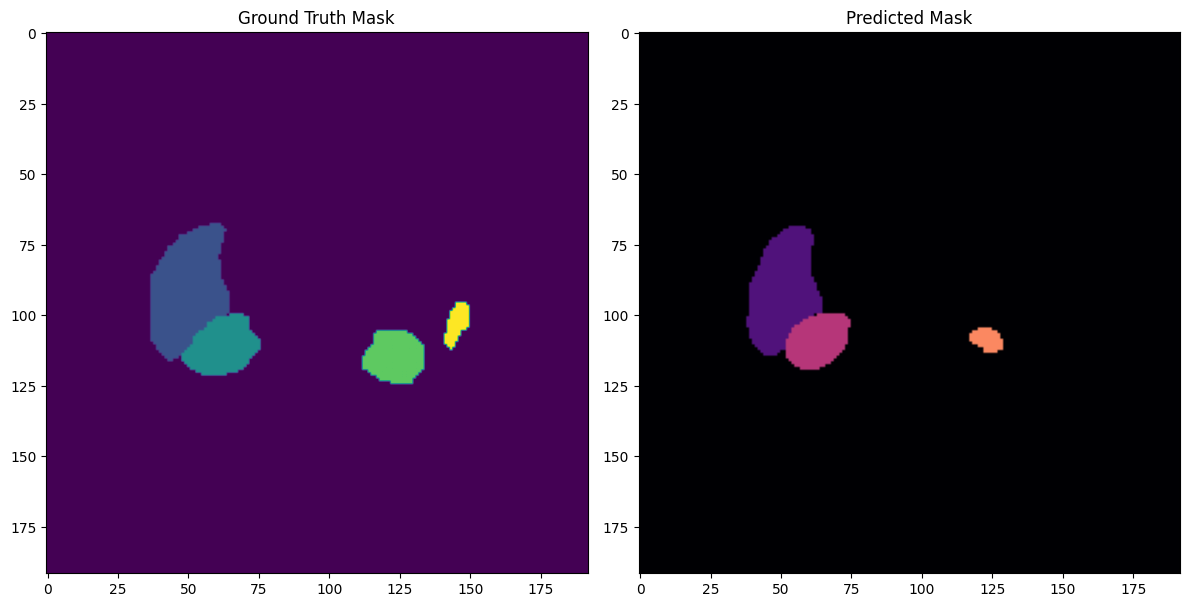

192/192 - 66s - loss: 0.0351 - accuracy: 0.9866 - mean_iou: 0.7625 - val_loss: 0.0441 - val_accuracy: 0.9859 - val_mean_iou: 0.5905 - lr: 0.0010 - 66s/epoch - 341ms/step
Epoch 3/1000


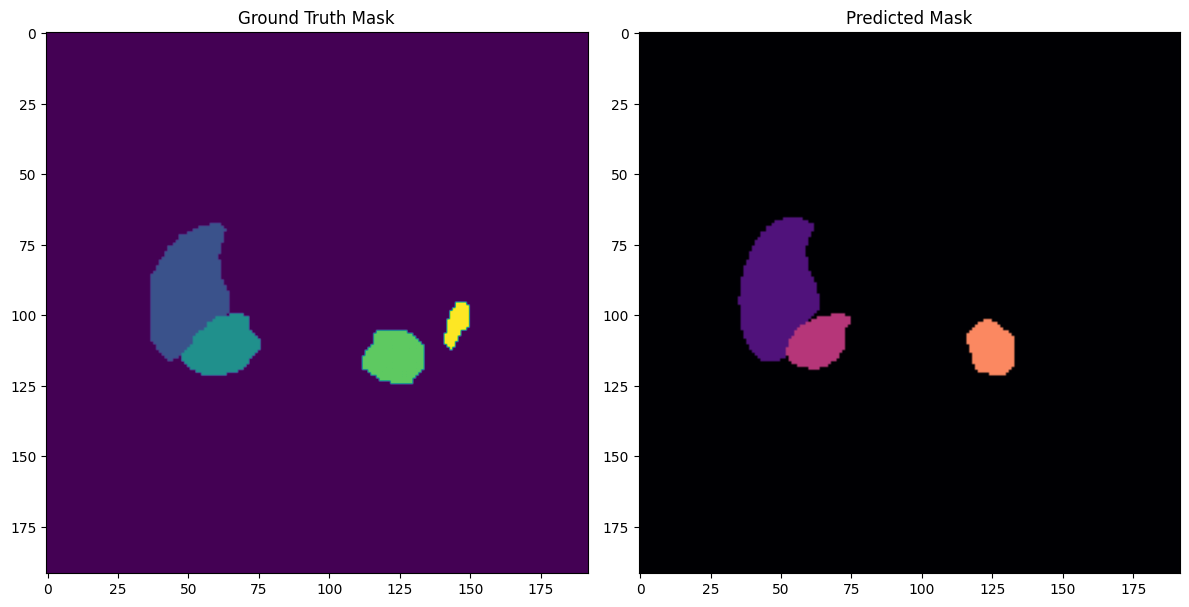

192/192 - 65s - loss: 0.0260 - accuracy: 0.9897 - mean_iou: 0.8247 - val_loss: 0.0468 - val_accuracy: 0.9856 - val_mean_iou: 0.5739 - lr: 0.0010 - 65s/epoch - 341ms/step
Epoch 4/1000


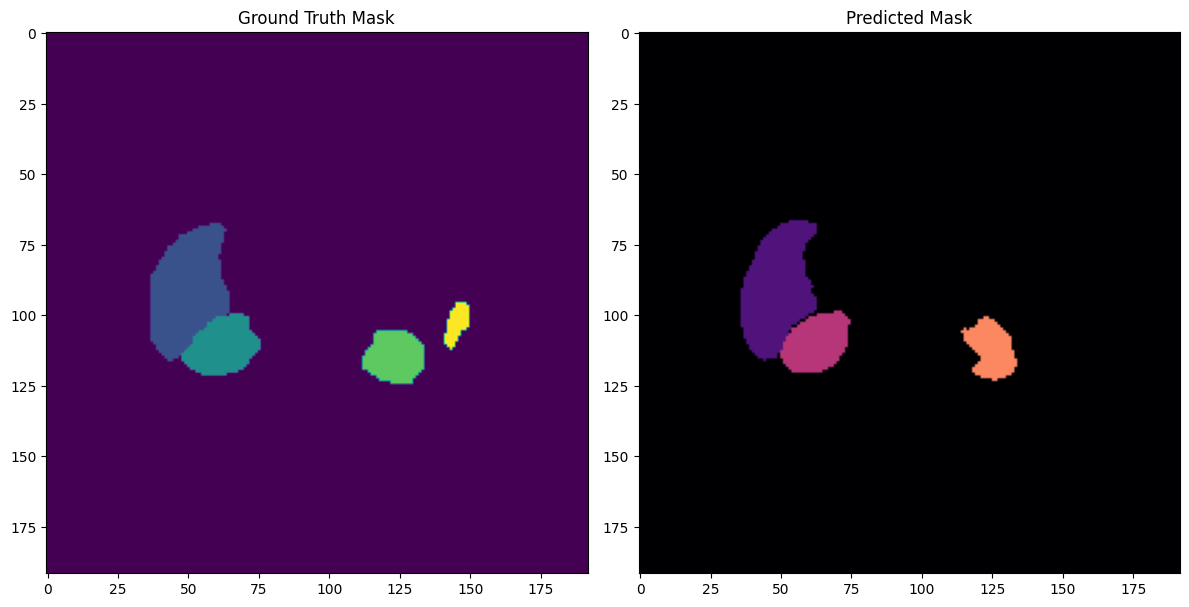

192/192 - 66s - loss: 0.0197 - accuracy: 0.9920 - mean_iou: 0.8686 - val_loss: 0.0322 - val_accuracy: 0.9879 - val_mean_iou: 0.6477 - lr: 1.0000e-04 - 66s/epoch - 342ms/step
Epoch 5/1000


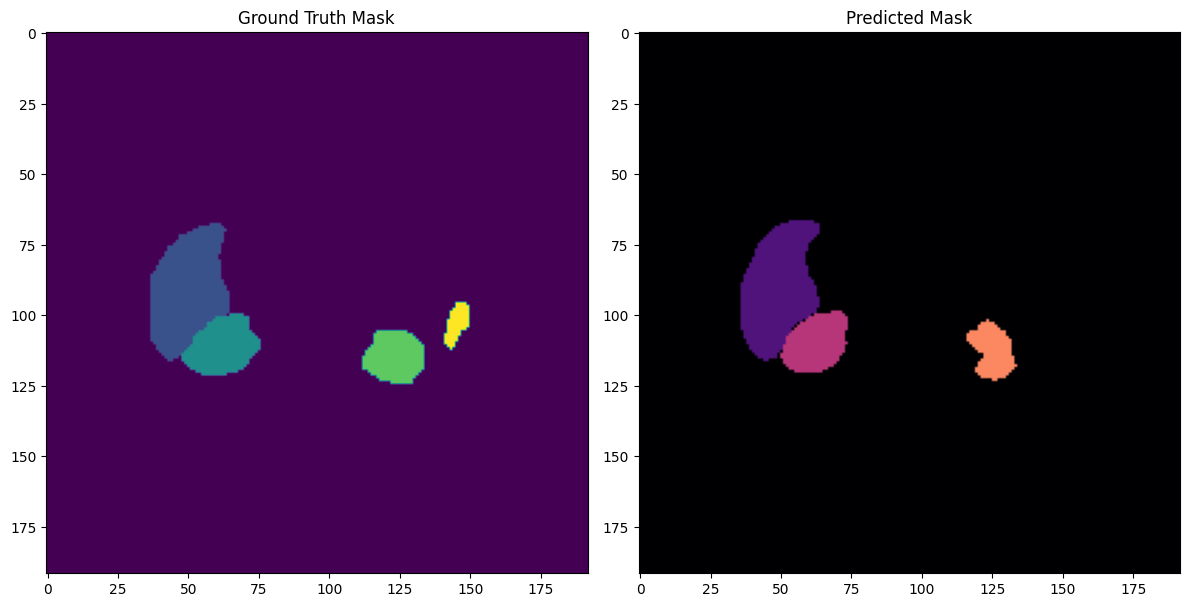

192/192 - 66s - loss: 0.0182 - accuracy: 0.9926 - mean_iou: 0.8768 - val_loss: 0.0329 - val_accuracy: 0.9875 - val_mean_iou: 0.6473 - lr: 1.0000e-04 - 66s/epoch - 342ms/step
Epoch 6/1000


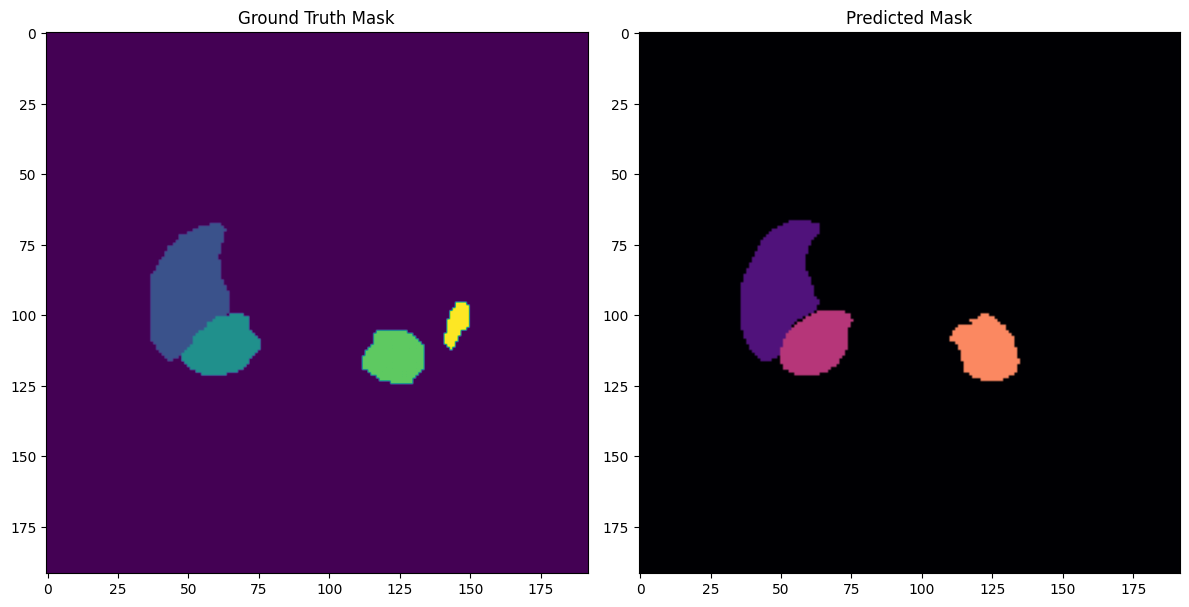

192/192 - 66s - loss: 0.0172 - accuracy: 0.9929 - mean_iou: 0.8825 - val_loss: 0.0260 - val_accuracy: 0.9898 - val_mean_iou: 0.7662 - lr: 1.0000e-05 - 66s/epoch - 342ms/step
Epoch 7/1000


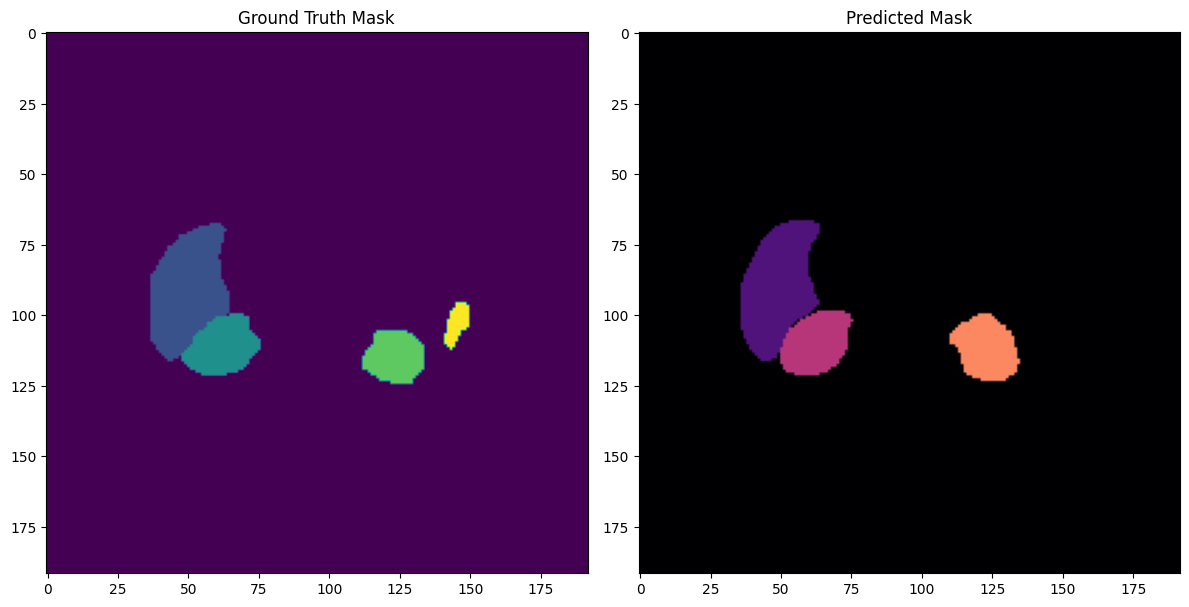

192/192 - 66s - loss: 0.0171 - accuracy: 0.9930 - mean_iou: 0.8838 - val_loss: 0.0258 - val_accuracy: 0.9899 - val_mean_iou: 0.7746 - lr: 1.0000e-05 - 66s/epoch - 343ms/step
Epoch 8/1000


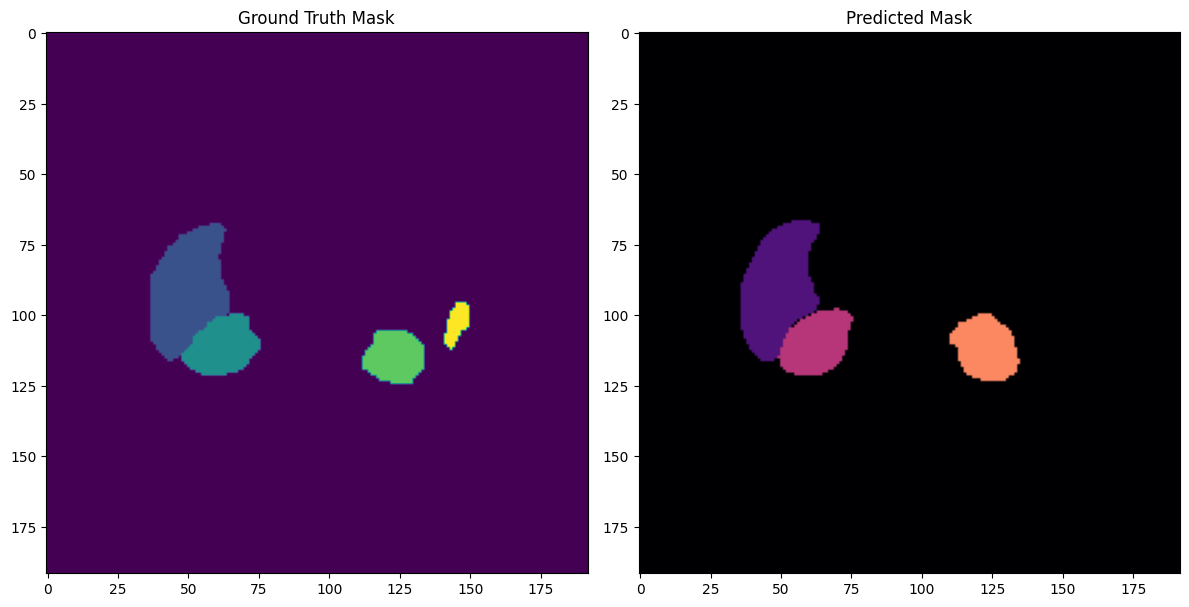

192/192 - 66s - loss: 0.0168 - accuracy: 0.9931 - mean_iou: 0.8854 - val_loss: 0.0255 - val_accuracy: 0.9901 - val_mean_iou: 0.7806 - lr: 1.0000e-05 - 66s/epoch - 343ms/step
Epoch 9/1000


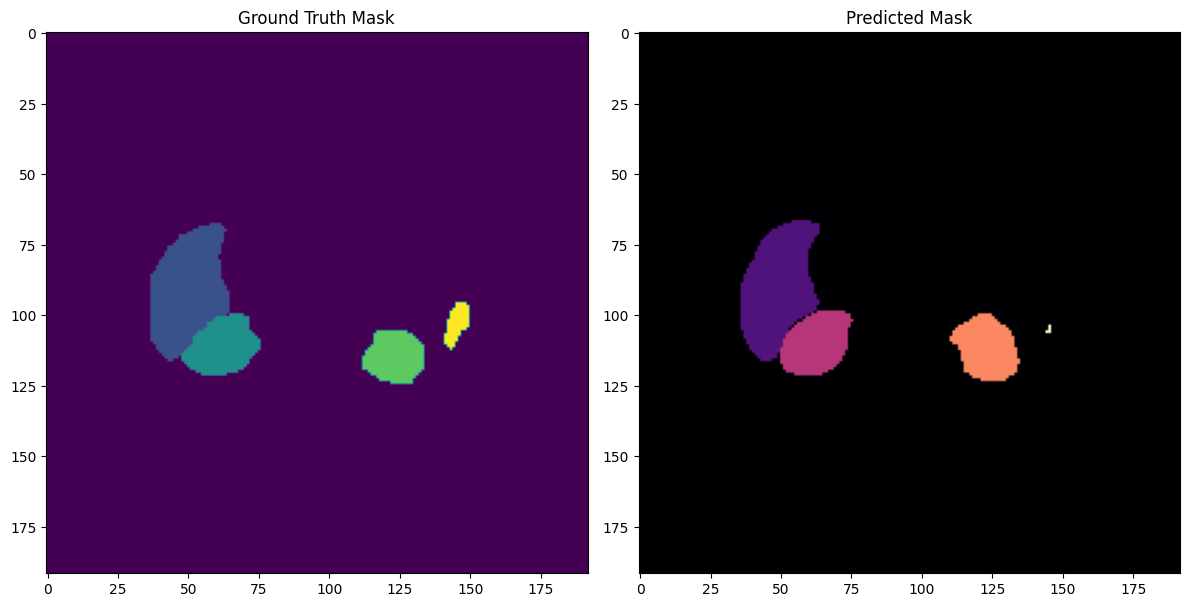

192/192 - 66s - loss: 0.0167 - accuracy: 0.9932 - mean_iou: 0.8863 - val_loss: 0.0268 - val_accuracy: 0.9895 - val_mean_iou: 0.7673 - lr: 1.0000e-05 - 66s/epoch - 342ms/step
Epoch 10/1000


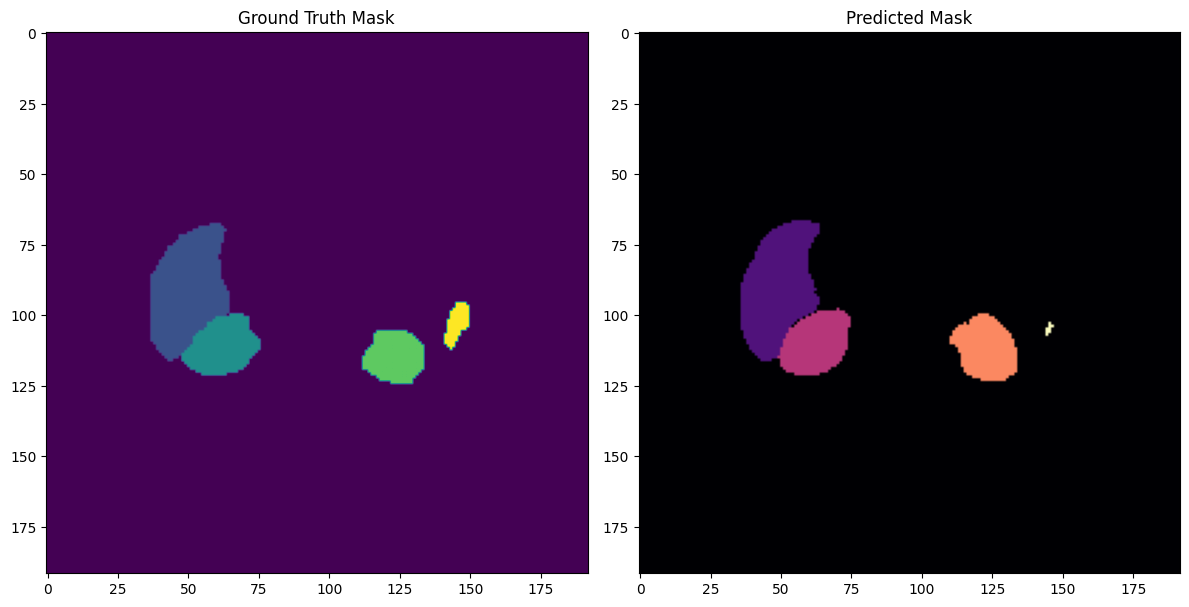

192/192 - 66s - loss: 0.0166 - accuracy: 0.9932 - mean_iou: 0.8872 - val_loss: 0.0270 - val_accuracy: 0.9896 - val_mean_iou: 0.7712 - lr: 1.0000e-05 - 66s/epoch - 342ms/step
Epoch 11/1000


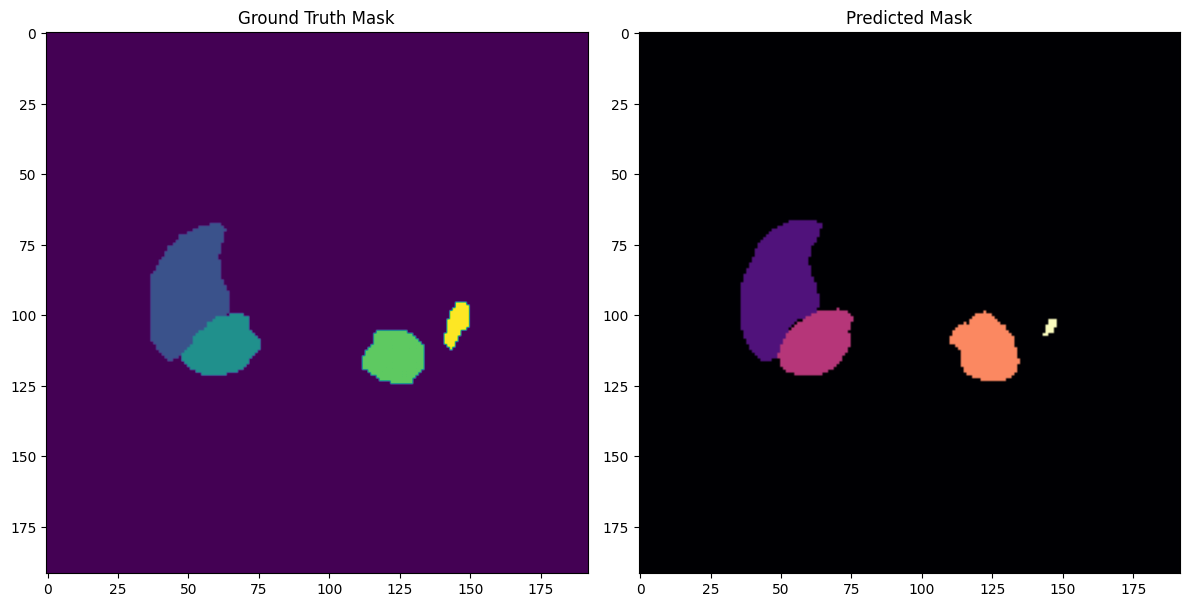

192/192 - 66s - loss: 0.0165 - accuracy: 0.9932 - mean_iou: 0.8864 - val_loss: 0.0277 - val_accuracy: 0.9891 - val_mean_iou: 0.7712 - lr: 1.0000e-05 - 66s/epoch - 342ms/step
Epoch 12/1000


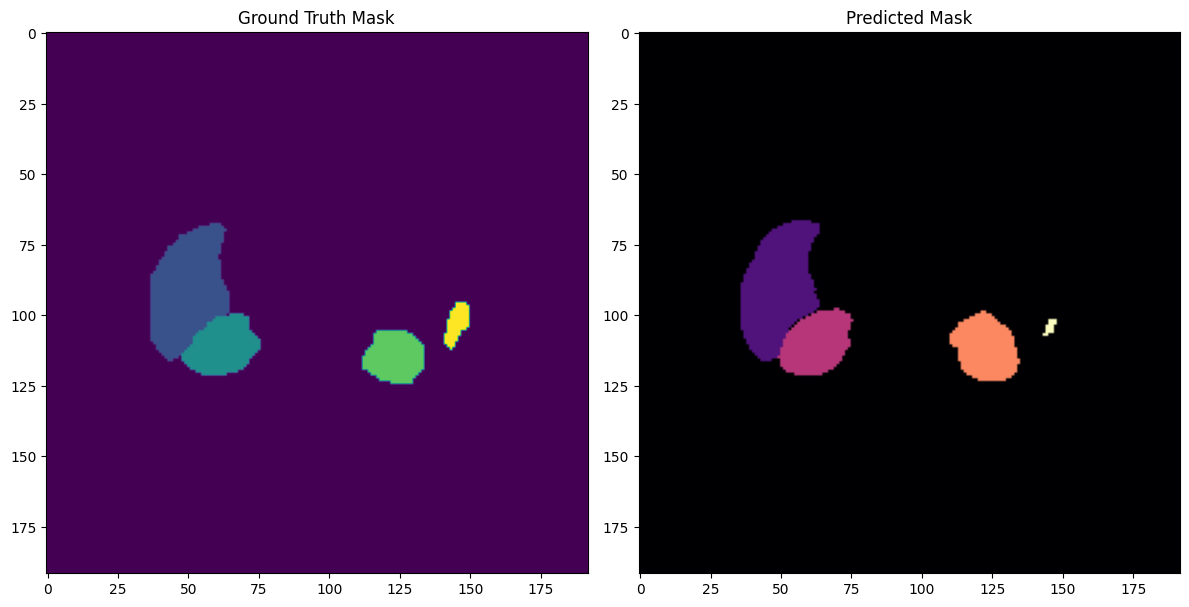

192/192 - 66s - loss: 0.0162 - accuracy: 0.9934 - mean_iou: 0.8891 - val_loss: 0.0264 - val_accuracy: 0.9898 - val_mean_iou: 0.7771 - lr: 1.0000e-05 - 66s/epoch - 342ms/step
Epoch 13/1000


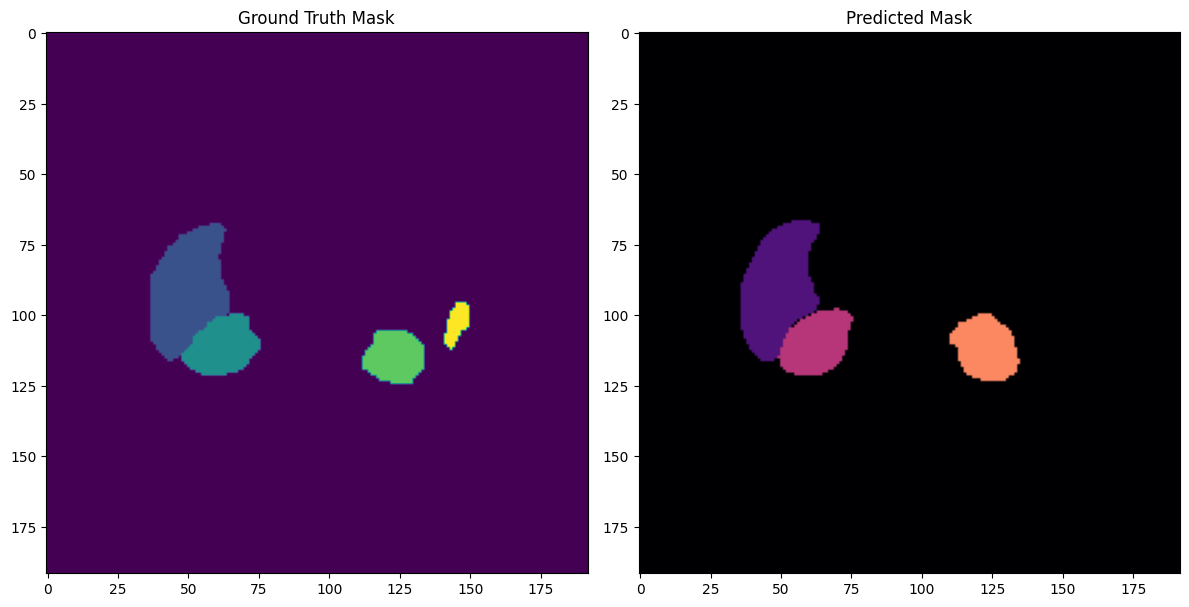

192/192 - 66s - loss: 0.0162 - accuracy: 0.9934 - mean_iou: 0.8892 - val_loss: 0.0273 - val_accuracy: 0.9896 - val_mean_iou: 0.7648 - lr: 1.0000e-05 - 66s/epoch - 342ms/step


In [75]:
history = model.fit(
    x=X_train,
    y=y_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_data = (X_val, y_val),
    callbacks=[early_stopping, viz_callback, scheduler],
    verbose=2
    )

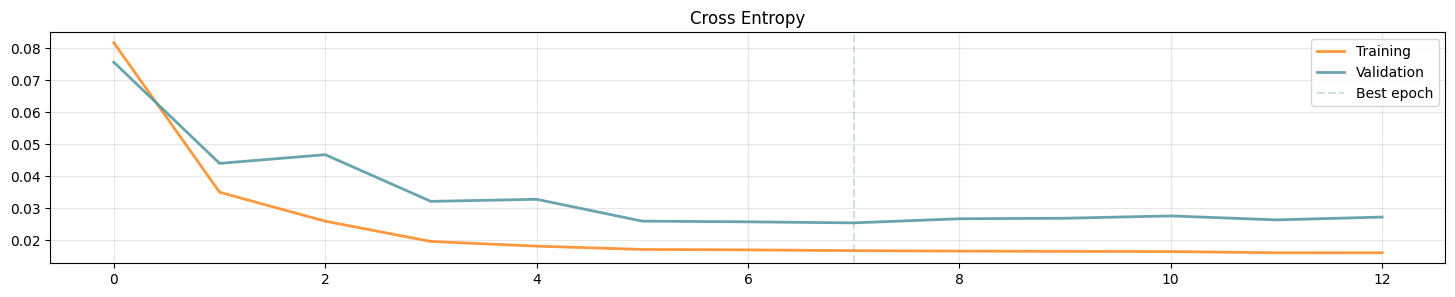

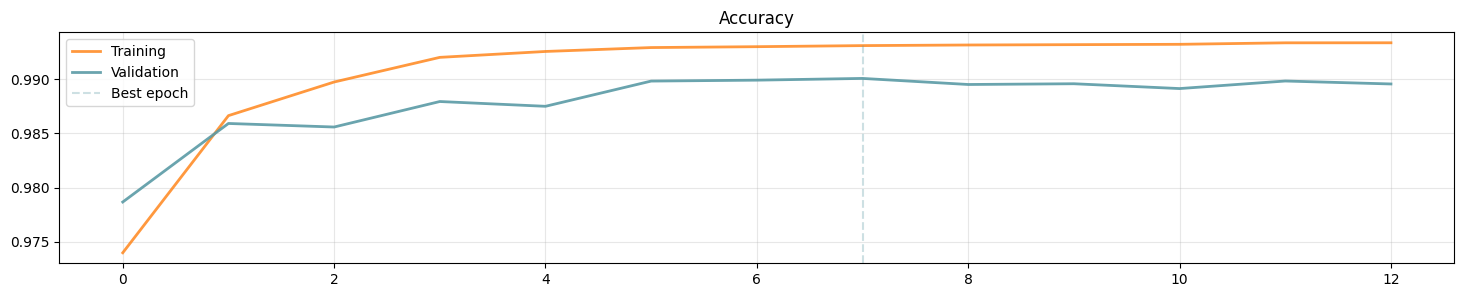

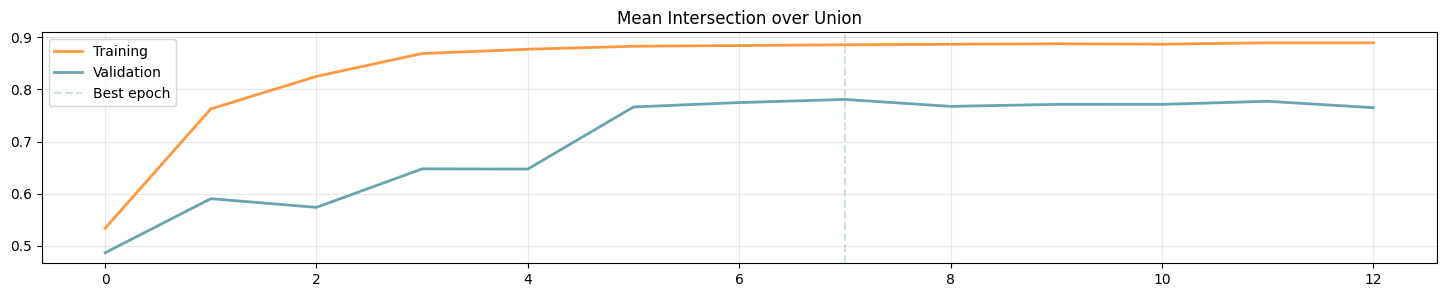

In [76]:
best_epoch = np.argmax(history.history['val_mean_iou'])
plt.figure(figsize=(18,3))
plt.plot(history.history['loss'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history.history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history.history['mean_iou'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history.history['val_mean_iou'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [77]:
model.save('UNet')


In [78]:
# del model

In [79]:
# Load UNet model without compiling
model = tfk.models.load_model('UNet', compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(learning_rate),
    metrics=["accuracy", UpdatedMeanIoU(num_classes=num_classes)]
)

# Display the model summary
# model.summary()

In [80]:
# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(X_test, y_test, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

Test Accuracy: 0.981
Test Mean Intersection over Union: 0.7396


# Function to plot triptychs for model predictions

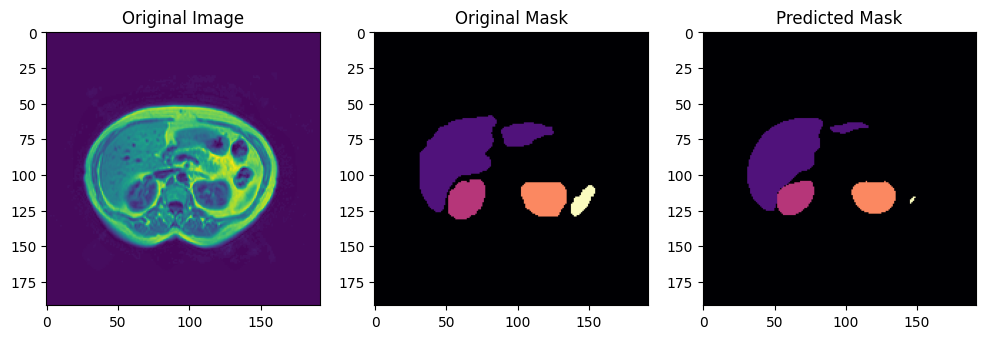

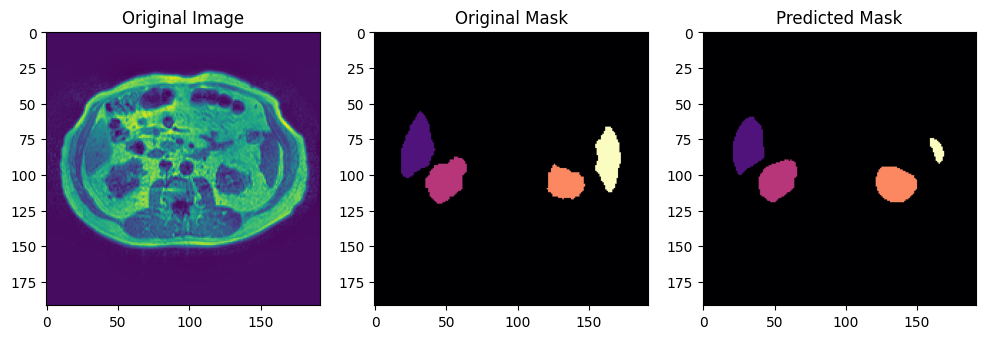

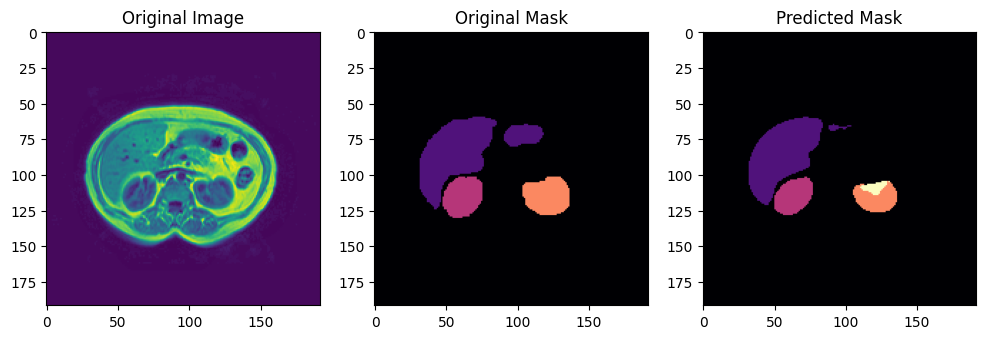

In [84]:
def plot_triptychs(data, labels, index=None):
    # If index is not specified, randomly select one
    if index is None:
        index = np.random.randint(0, len(data))

    # Generate predictions for the selected index
    pred = model.predict(np.expand_dims(data[index], axis=0), verbose=0)
    pred = np.array(tf.math.argmax(pred, axis=-1))
    pred = np.reshape(pred, (192, 192, 1))

    # Plot the original image, original mask, and predicted mask
    fig, axes = plt.subplots(1, 3, figsize=(12, 12))
    axes[0].set_title("Original Image")
    axes[0].imshow(data[index])
    axes[1].set_title("Original Mask")
    colored_image = display_color_mapped_image_continuous(labels[index])
    axes[1].imshow(np.squeeze(colored_image))
    axes[2].set_title("Predicted Mask")
    colored_image = display_color_mapped_image_continuous(pred)
    axes[2].imshow(np.squeeze(colored_image))
    plt.show()

# Plot triptychs for three random samples from the test set
plot_triptychs(X_test, y_test)
plot_triptychs(X_test, y_test)
plot_triptychs(X_test, y_test)